In [3]:
import torch
import numpy as np

from torch import nn, optim
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Define a model:
class Network(nn.Module):
    def __init__(self, vocab, n_hidden, n_layers, do=0.5):
        super().__init__()
        
        self.vocab = vocab
        self.n_hidden = n_hidden 
        self.lstm = nn.LSTM(len(vocab), n_hidden, n_layers, batch_first=True, dropout=do)
        self.fc   = nn.Linear(n_hidden, len(vocab))
        
    def forward(self, x, hs=None):
        x, hs = self.lstm(x, hs)          # -> (batch_size, seq_len, n_hidden)
        x = x.reshape(-1, self.n_hidden)  # -> (batch_size * seq_len, n_hidden)
        out = self.fc(x)                  # -> (batch_size * seq_len, vocab_size)
        
        return out, hs 

In [5]:
# define a batching method:
def get_batches(data, n_seq, seq_len):
    """
    Takes data of shape (n_samples, n_features), returns batches
    of shape (n_seq, seq_len, n_features)
    """
    n_features = data.shape[1]
    n_chars    = n_seq * seq_len
    n_batches  = int(np.floor(len(data) / n_chars))
    n_keep     = n_batches * n_chars
    
    inputs  = data[:n_keep]
    targets = np.append(data[1:], data[0]).reshape(data.shape)
    targets = targets[:n_keep]
    
    inputs = inputs.reshape(n_seq, -1, n_features)
    targets = targets.reshape(n_seq, -1, n_features)
    
    for i in range(0, inputs.shape[1], seq_len):
        x = inputs[:, i: i + seq_len]
        y = targets[:, i: i + seq_len]
        yield x,y
        

In [1]:
def train(model, data, batch_size, seq_len, epochs, lr=0.01, clip=5, valid=None):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    
    opt = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    encoder = OneHotEncoder(sparse=False).fit(model.vocab.reshape(-1, 1))
    data = encoder.transform(data)
    if valid is not None:
        
        valid = encoder.transform(valid)
        
          
    train_loss = []
    valid_loss = []
    
    for e in range(epochs):

        hs = None
        t_loss = 0
        v_loss = 0

        for x, y in get_batches(data, batch_size, seq_len):
            opt.zero_grad()
            x = torch.tensor(x).float()
            x = x.to(device)
            
            out, hs = model(x, hs)
            hs = tuple([h.data for h in hs])

            # target should not be one-hot encoded for CE Loss
            y = y.reshape(-1, len(model.vocab))
            y = encoder.inverse_transform(y)
            y = torch.from_numpy(y).long().to(device)

            loss = criterion(out, y.squeeze())
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            opt.step()
            
            t_loss += loss.item()
            
        if valid is not None:
            model.eval()
            hs = None
            with torch.no_grad():
                for x, y in get_batches(valid, batch_size, seq_len):

                    x = torch.tensor(x).float()
                    x = x.to(device)

                    y = y.reshape(-1, len(model.vocab))
                    y = encoder.inverse_transform(y)
                    y = torch.from_numpy(y).long().to(device)

                    out, hs = model(x, hs)
                    hs = tuple([h.data for h in hs])

                    loss = criterion(out, y)
                    v_loss += loss.item()

                valid_loss.append(np.mean(v_loss))
                model.train()
        
        train_loss.append(np.mean(t_loss))
        
        if e % (epochs // 10) == 0:
            print(f'Training Loss: {train_loss[-1]}')
            
    plt.plot(train_loss)

SyntaxError: invalid syntax (<ipython-input-1-0698df4227d2>, line 44)

In [23]:
# get and pre-process data:
with open('data/texts/anna.txt') as data:
    text = data.read()

vocab = sorted(set(text))
int2char = {i:ch for i, ch in enumerate(vocab)}
char2int = {ch: i for i, ch in int2char.items()}

# label encode and reshape to (n_samples, n_features)
encoded = np.array([char2int[ch] for ch in text]).reshape(-1, 1)
vocab = np.array([char2int[ch] for ch in vocab]).reshape(-1, 1)

In [24]:
n_hidden = 512
n_layers = 2

model = Network(vocab, n_hidden, n_layers)
model

Network(
  (lstm): LSTM(83, 512, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=512, out_features=83, bias=True)
)

Training Loss: 476.0572726726532
Training Loss: 410.5283603668213
Training Loss: 368.2233211994171
Training Loss: 344.6959447860718
Training Loss: 328.9363555908203
Training Loss: 316.15604078769684
Training Loss: 307.36604356765747
Training Loss: 300.76547610759735
Training Loss: 293.9298862218857
Training Loss: 289.11690747737885


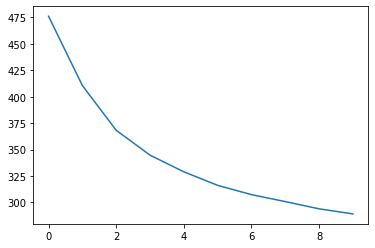

In [25]:
batch_size = 128
seq_len = 100
epochs = 10
lr = 0.01

train(model, encoded, batch_size, seq_len, epochs, lr=lr)